# Pravin Prakashrao Kulkarni

### GitHub: https://github.com/pravink83/IntroToNLP

In [174]:
# Import Libraries

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn

%matplotlib inline

sns.set(color_codes=True)

pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

!pip install contractions

import re
import string
import unicodedata
import contractions
from bs4 import BeautifulSoup
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [175]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
twitterData = pd.read_csv('/content/drive/MyDrive/AIML/MyProjects/9-IntroductionToNaturalLanguageProcessing/Tweets.csv')

In [177]:
twitterData.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Preliminary Analysis

In [178]:
# Shape of data
twitterData.shape

(14640, 15)

In [179]:
# Data Types
twitterData.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [180]:
# Null check
twitterData.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [181]:
# number of unique values
twitterData.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [182]:
# Describe
twitterData.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [183]:
# Drop unwanted columns i.e. columns other than text and airline_sentiment

twitterData.drop(labels=['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence',
                         'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count',
                         'tweet_coord', 'tweet_created', 'tweet_location' , 'user_timezone'], axis=1, inplace=True)

In [184]:
# Shape of data
twitterData.shape

(14640, 2)

In [185]:
twitterData.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [186]:
# Null check
twitterData.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

# Data Pre-Processing

In [187]:
# Html tag removal

# Create BS4 Beautiful Soup object and get text for each record.

twitterData['text'] = twitterData['text'].apply(lambda txt: BeautifulSoup(txt, "html.parser").get_text())

twitterData.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [188]:
# Convert non-ASCII to English characters.

twitterData['text'] = twitterData['text'].apply(lambda txt: unicodedata.normalize('NFKD', txt).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

twitterData.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [189]:
# Replace contractions in string. (e.g. replace I'm --> I am) and so on.

# Create contractions object and get text for each record.

twitterData['text'] = twitterData['text'].apply(lambda txt: contractions.fix(txt))

twitterData.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [190]:
# Remove numbers using Regular Expression

twitterData['text'] = twitterData['text'].apply(lambda txt: re.sub(r'\d+', '', txt))

twitterData.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


In [191]:
# Remove Special characters & Punctuations using Regular Expression
# keep spaces and word boundaries to tokenize in next steps.

twitterData['text'] = twitterData['text'].apply(lambda txt: re.sub(r'[^\w\s\b]', '', txt))

twitterData.head()

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you have added commercials to the experience tacky
2,neutral,VirginAmerica I did not today Must mean I need to take another trip
3,negative,VirginAmerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,VirginAmerica and it is a really big bad thing about it


In [192]:
# Convert to lower case. converting to lower case after tokenization takes more time than before tokenization due to iterations over the tokens.

twitterData['text'] = twitterData['text'].apply(lambda txt: txt.lower())

twitterData.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you have added commercials to the experience tacky
2,neutral,virginamerica i did not today must mean i need to take another trip
3,negative,virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,virginamerica and it is a really big bad thing about it


In [193]:
# Tokenize

# Create word tokenizer object and tokenize each sentence

twitterData['Tokens'] = twitterData['text'].apply(lambda txt: word_tokenize(txt))

twitterData.head()

,airline_sentiment,text,Tokens
0,neutral,virginamerica what dhepburn said,"[virginamerica, what, dhepburn, said]"
1,positive,virginamerica plus you have added commercials to the experience tacky,"[virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]"
2,neutral,virginamerica i did not today must mean i need to take another trip,"[virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,"[virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,virginamerica and it is a really big bad thing about it,"[virginamerica, and, it, is, a, really, big, bad, thing, about, it]"


In [194]:
# Remove stopwords

stopWDs = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopWDs = list(set(stopWDs) - set(customlist))  

def removeStopwords(txt):
  tokens = []
  for wd in txt:
    if wd not in stopWDs:
      tokens.append(wd)
  return tokens


# Iterate each row and remove the stop words

twitterData['Tokens'] = twitterData['Tokens'].apply(lambda tokens: removeStopwords(tokens))

twitterData.head()

,airline_sentiment,text,Tokens
0,neutral,virginamerica what dhepburn said,"[virginamerica, dhepburn, said]"
1,positive,virginamerica plus you have added commercials to the experience tacky,"[virginamerica, plus, added, commercials, experience, tacky]"
2,neutral,virginamerica i did not today must mean i need to take another trip,"[virginamerica, not, today, must, mean, need, take, another, trip]"
3,negative,virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, little, recourse]"
4,negative,virginamerica and it is a really big bad thing about it,"[virginamerica, really, big, bad, thing]"


In [195]:
# Lemmatization

lemm = WordNetLemmatizer()

def lemmatizeWords(words):
  lemmTokens = []
  for wd in words:
    lemmTokens.append(lemm.lemmatize(wd, pos='v'))
  return lemmTokens


# Iterate each row and lemmatize tokens

twitterData['Tokens'] = twitterData['Tokens'].apply(lambda tokens: lemmatizeWords(tokens))

twitterData.head()

,airline_sentiment,text,Tokens
0,neutral,virginamerica what dhepburn said,"[virginamerica, dhepburn, say]"
1,positive,virginamerica plus you have added commercials to the experience tacky,"[virginamerica, plus, add, commercials, experience, tacky]"
2,neutral,virginamerica i did not today must mean i need to take another trip,"[virginamerica, not, today, must, mean, need, take, another, trip]"
3,negative,virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, face, little, recourse]"
4,negative,virginamerica and it is a really big bad thing about it,"[virginamerica, really, big, bad, thing]"


In [196]:
# Stemming

# stemmer = PorterStemmer()

# def stemmWords(words):
#   stemmTokens = []
#   for wd in words:
#     stemmTokens.append(stemmer.stem(wd))
#   return stemmTokens


# # Iterate each row and lemmatize tokens

# twitterData['Tokens'] = twitterData['Tokens'].apply(lambda tokens: stemmWords(tokens))

# twitterData.head()

In [197]:
# Join the tokens

twitterData['Tokens'] = twitterData['Tokens'].apply(lambda tokens: ' '.join(tokens))

twitterData.head()

,airline_sentiment,text,Tokens
0,neutral,virginamerica what dhepburn said,virginamerica dhepburn say
1,positive,virginamerica plus you have added commercials to the experience tacky,virginamerica plus add commercials experience tacky
2,neutral,virginamerica i did not today must mean i need to take another trip,virginamerica not today must mean need take another trip
3,negative,virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica and it is a really big bad thing about it,virginamerica really big bad thing


In [198]:
labels = twitterData['airline_sentiment']

In [199]:
random = 7
rowCount = twitterData.shape[0]
rowCount

14640

In [200]:
classList = twitterData['airline_sentiment'].unique()
classList

array(['neutral', 'positive', 'negative'], dtype=object)

In [201]:
# Define dataframe to collect results
# Various model scores for testing dataset will be stored in this dataframe.

resultsFrame = pd.DataFrame(columns=['Vectorizer', 'Sentiment', 'ConfustionMatrix', 'True Positive', 'False Positive', 'True Negative', 'False Negative', 
    'Recall Score', 'Precision Score', 'Accuracy Score', 'F1 Score', 'Parameters', 'FeatureCount' ])

In [202]:
def analyzeSentiments(name, vectorizer, X_Tokens, Y_Sentiments, randomState, rowCount, resultsFrame, classList):
  vectors = vectorizer.fit_transform(X_Tokens)
  print("vectors.shape", vectors.shape)
  featureCount = len(vectorizer.vocabulary_)
  vectors = vectors.toarray()
  # print('vectors')
  # print(vectors)
  X_train, X_test, Y_train, Y_test = train_test_split(vectors, Y_Sentiments, test_size=0.2, random_state=randomState)
  # Verify the split
  print("Total Rows in Train Data - Independents: ", len(X_train), '   ', len(X_train)/rowCount*100, ' %')
  print("Total Rows in Test Data - Independents: ", len(X_test), '   ', len(X_test)/rowCount*100, ' %')
  print()
  print("Total Rows in Train Data - Dependents: ", len(Y_train), '   ', len(Y_train)/rowCount*100, ' %')
  print("Total Rows in Test Data - Dependents: ", len(Y_test), '   ', len(Y_test)/rowCount*100, ' %')
  results = []
  # Create RandomForest Classifier with various parameters and record performance.
  criterion = ['gini', 'entropy']
  for c in criterion:
    print("Creating Model with criterion ", c)
    rfcl = RandomForestClassifier(criterion=c, n_estimators=50, random_state=random)
    preditResults = fitAndPredict(name, rfcl, X_train, Y_train, X_test, Y_test, featureCount, classList)
    print("Model prediction complete with criterion ", c)
  for resultRow in preditResults:
    results.append(resultRow)
  
  return results

In [203]:
# Define a common function to fit the model and calculate various scores and return as a series.

def fitAndPredict(name, model, x_train, y_train, x_test, y_test, featureCount, classList):
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    # print(y_predict)
    accuracy = model.score(x_test, y_test)
    multi_confusion = multilabel_confusion_matrix(y_test, y_predict)
    recall = recall_score(y_test, y_predict, average='weighted')
    precision = precision_score(y_test, y_predict, average='weighted')
    f1 = f1_score(y_test, y_predict, average='weighted')
    params = str(model.get_params())
    results = []
    for classIndex in range(len(classList)):
          className = classList[classIndex]
          confustionMatrix = multi_confusion[classIndex]
          tn, fp, fn, tp = multi_confusion[classIndex].ravel()
          resultRow = pd.Series([name, className, confustionMatrix, tp, fp, tn, fn, recall, precision, accuracy, f1, params, 
                                 featureCount], index=resultsFrame.columns)
          results.append(resultRow)
    return results

# Build Models for all features

In [204]:
# Count Vectorizer
countVerctorizer = CountVectorizer()
results = analyzeSentiments('Count Vectorizer', countVerctorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 12612)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


In [205]:
# TF-IDF Vectorizer
tfidfVectorizer = TfidfVectorizer()
results = analyzeSentiments('TF-IDF Vectorizer', tfidfVectorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 12612)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


# Build model for 6000 (approx. half) features

In [206]:
# Count Vectorizer
countVerctorizer = CountVectorizer(max_features=6000)
results = analyzeSentiments('Count Vectorizer', countVerctorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 6000)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


In [207]:
# TF-IDF Vectorizer
tfidfVectorizer = TfidfVectorizer(max_features=6000)
results = analyzeSentiments('TF-IDF Vectorizer', tfidfVectorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 6000)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


# Build model for 3000 (approx. 25%) features

In [208]:
# Count Vectorizer
countVerctorizer = CountVectorizer(max_features=3000)
results = analyzeSentiments('Count Vectorizer', countVerctorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 3000)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


In [209]:
# TF-IDF Vectorizer
tfidfVectorizer = TfidfVectorizer(max_features=3000)
results = analyzeSentiments('TF-IDF Vectorizer', tfidfVectorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 3000)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


# Build model for 1000 features

In [210]:
# Count Vectorizer
countVerctorizer = CountVectorizer(max_features=1000)
results = analyzeSentiments('Count Vectorizer', countVerctorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 1000)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


In [211]:
# TF-IDF Vectorizer
tfidfVectorizer = TfidfVectorizer(max_features=1000)
results = analyzeSentiments('TF-IDF Vectorizer', tfidfVectorizer, twitterData['Tokens'], labels, random, rowCount, resultsFrame, classList)
for resultRow in results:
  resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

vectors.shape (14640, 1000)
Total Rows in Train Data - Independents:  11712     80.0  %
Total Rows in Test Data - Independents:  2928     20.0  %

Total Rows in Train Data - Dependents:  11712     80.0  %
Total Rows in Test Data - Dependents:  2928     20.0  %
Creating Model with criterion  gini
Model prediction complete with criterion  gini
Creating Model with criterion  entropy
Model prediction complete with criterion  entropy


# Analyze results

In [212]:
resultsFrame

,Vectorizer,Sentiment,ConfustionMatrix,True Positive,False Positive,True Negative,False Negative,Recall Score,Precision Score,Accuracy Score,F1 Score,Parameters,FeatureCount
0,Count Vectorizer,neutral,"[[711, 383], [150, 1684]]",1684,383,711,150,0.771516,0.759792,0.771516,0.760555,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}",12612
1,Count Vectorizer,positive,"[[2122, 178], [313, 315]]",315,178,2122,313,0.771516,0.759792,0.771516,0.760555,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}",12612
2,Count Vectorizer,negative,"[[2354, 108], [206, 260]]",260,108,2354,206,0.771516,0.759792,0.771516,0.760555,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}",12612
3,TF-IDF Vectorizer,neutral,"[[603, 491], [97, 1737]]",1737,491,603,97,0.761270,0.750378,0.761270,0.740412,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}",12612
4,TF-IDF Vectorizer,positive,"[[2167, 133], [370, 258]]",258,133,2167,370,0.761270,0.750378,0.761270,0.740412,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}",12612
5,TF-IDF Vectorizer,negative,"[[2387, 75], [232, 234]]",234,75,2387,232,0.761270,0.750378,0.761270,0.740412,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}",12612
6,Count Vectorizer,neutral,"[[710, 384], [165, 1669]]",1669,384,710,165,0.761954,0.748949,0.761954,0.751042,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}",6000
7,Count Vectorizer,positive,"[[2116, 184], [323, 305]]",305,184,2116,323

In [213]:
resultsFrame.shape

(24, 13)

In [214]:
comparedResults = resultsFrame.groupby(by=['Vectorizer',  'FeatureCount']).agg(
    {
        'Accuracy Score': np.max,
        'Recall Score': np.max,
        'Precision Score': np.max,
        'F1 Score': np.max
    })

In [215]:
comparedResults

Accuracy Score  ...  F1 Score
Vectorizer        FeatureCount                  ...          
Count Vectorizer  1000                0.757514  ...  0.748791
                  3000                0.754098  ...  0.743279
                  6000                0.761954  ...  0.751042
                  12612               0.771516  ...  0.760555
TF-IDF Vectorizer 1000                0.754781  ...  0.738116
                  3000                0.760246  ...  0.742773
                  6000                0.758538  ...  0.738654
                  12612               0.761270  ...  0.740412

[8 rows x 4 columns]

In [216]:
# Confusion Matrices

def printClasswiseConfusionMatrix(classIndex, classList, tn, fp, fn, tp, confusionMatrix):
  print("True Negatives : ", tn)
  print("False Positives : ", fp)
  print("False Negatives : ", fn)
  print("True Positives : ", tp)

  plt.figure(figsize=(10,5))
  plt.title("Confusion metrics for class " + classList[classIndex])
  sns.heatmap(confusionMatrix, annot=True, fmt='', cmap="YlGnBu", xticklabels = ['Predicted 0','Predicted 1'] , yticklabels = ['Actual 0','Actual 1']);

In [217]:
# Looking at the above comparison result, Count Vectorizer is proven to be best in this case.

# Lets draw confusion matrices for count vectorizer results only.

finalResults = resultsFrame[(resultsFrame['Vectorizer'] == 'Count Vectorizer') & (resultsFrame['FeatureCount'] == 12612)]

True Negatives :  711
False Positives :  383
False Negatives :  150
True Positives :  1684


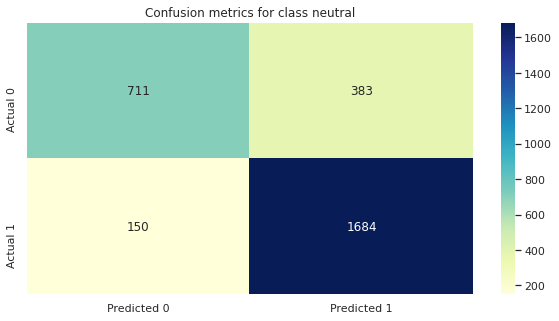

In [218]:
classIndex = 0
tp = finalResults.iloc[classIndex]['True Positive']
fp = finalResults.iloc[classIndex]['False Positive']
tn = finalResults.iloc[classIndex]['True Negative']
fn = finalResults.iloc[classIndex]['False Negative']
cf = finalResults.iloc[classIndex]['ConfustionMatrix']
printClasswiseConfusionMatrix(classIndex, classList, tn, fp, fn, tp, cf)

True Negatives :  2122
False Positives :  178
False Negatives :  313
True Positives :  315


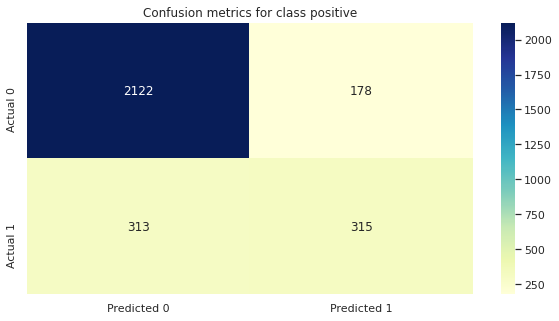

In [219]:
classIndex = 1
tp = finalResults.iloc[classIndex]['True Positive']
fp = finalResults.iloc[classIndex]['False Positive']
tn = finalResults.iloc[classIndex]['True Negative']
fn = finalResults.iloc[classIndex]['False Negative']
cf = finalResults.iloc[classIndex]['ConfustionMatrix']
printClasswiseConfusionMatrix(classIndex, classList, tn, fp, fn, tp, cf)

True Negatives :  2354
False Positives :  108
False Negatives :  206
True Positives :  260


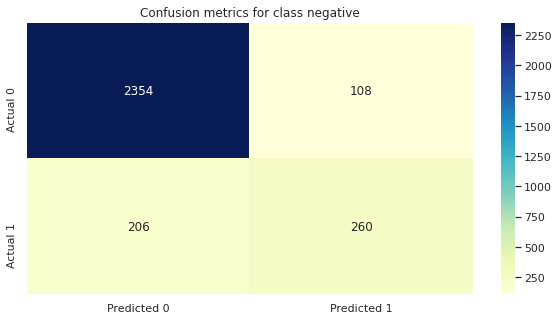

In [220]:
classIndex = 2
tp = finalResults.iloc[classIndex]['True Positive']
fp = finalResults.iloc[classIndex]['False Positive']
tn = finalResults.iloc[classIndex]['True Negative']
fn = finalResults.iloc[classIndex]['False Negative']
cf = finalResults.iloc[classIndex]['ConfustionMatrix']
printClasswiseConfusionMatrix(classIndex, classList, tn, fp, fn, tp, cf)

# Vader Sentiment Analysis



In [221]:
def analyzeSentimentsWithVader(tokens):
  text=SentimentIntensityAnalyzer()
  score=text.polarity_scores(tokens)
  if score['neg'] > score['neu'] and score['neg'] > score['pos']:
    return 'negative'
  elif score['neu'] > score['neg'] and score['neu'] > score['pos']:
    return 'neutral'
  elif score['pos'] > score['neu'] and score['pos'] > score['neg']:
    return 'positive'
  else:
    return 'neutral'

twitterData['VaderPredictions'] = twitterData['Tokens'].apply(lambda tokens: analyzeSentimentsWithVader(tokens))

twitterData.head()

,airline_sentiment,text,Tokens,VaderPredictions
0,neutral,virginamerica what dhepburn said,virginamerica dhepburn say,neutral
1,positive,virginamerica plus you have added commercials to the experience tacky,virginamerica plus add commercials experience tacky,neutral
2,neutral,virginamerica i did not today must mean i need to take another trip,virginamerica not today must mean need take another trip,neutral
3,negative,virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,neutral
4,negative,virginamerica and it is a really big bad thing about it,virginamerica really big bad thing,neutral


In [222]:
y_test = twitterData['airline_sentiment']
y_predict = twitterData['VaderPredictions']

accuracy = accuracy_score(y_test, y_predict)
multi_confusion = multilabel_confusion_matrix(y_test, y_predict)
recall = recall_score(y_test, y_predict, average='weighted')
precision = precision_score(y_test, y_predict, average='weighted')
f1 = f1_score(y_test, y_predict, average='weighted')

print("Vader Accuracy", accuracy)
print("Vader Recall", recall)
print("Vader Precision", precision)
print("Vader F1 score", f1)

Vader Accuracy 0.2796448087431694
Vader Recall 0.2796448087431694
Vader Precision 0.7357566535436587
Vader F1 score 0.19975277789971388


True Negatives :  5433
False Positives :  29
False Negatives :  8817
True Positives :  361


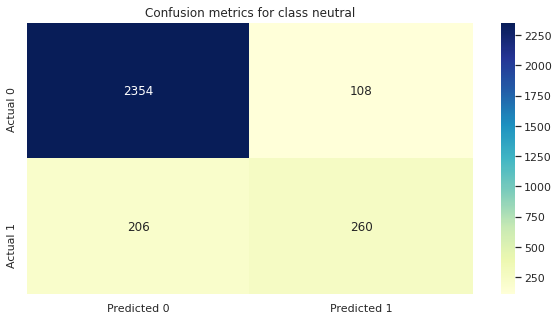

In [223]:
classIndex = 0
tn, fp, fn, tp = multi_confusion[classIndex].ravel()
printClasswiseConfusionMatrix(classIndex, classList, tn, fp, fn, tp, cf)

True Negatives :  1447
False Positives :  10094
False Negatives :  239
True Positives :  2860


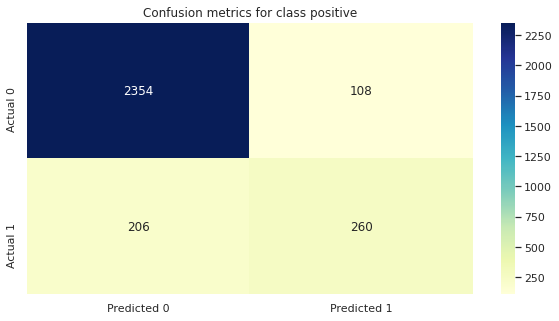

In [224]:
classIndex = 1
tn, fp, fn, tp = multi_confusion[classIndex].ravel()
printClasswiseConfusionMatrix(classIndex, classList, tn, fp, fn, tp, cf)

True Negatives :  11854
False Positives :  423
False Negatives :  1490
True Positives :  873


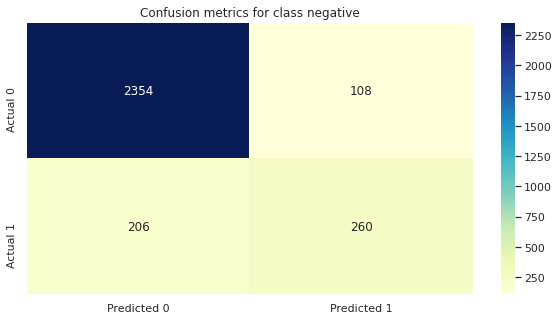

In [225]:
classIndex = 2
tn, fp, fn, tp = multi_confusion[classIndex].ravel()
printClasswiseConfusionMatrix(classIndex, classList, tn, fp, fn, tp, cf)

# Summary & Conclusion

### Data Pre-processing

<p><b>HTML tag removal</b> - For the data coming from websites,
it is necessary to remove the HTML tags, so that whatever is the real data will
remain for analysis.</p>



<p><b>Non-ASCII character removal</b> - Removing non-ASCII
characters helps in minimizing number to tokens when the non-ASCII ascended
tokens matches with similar English tokens. This also helps in better
predictions.</p>



<p><b>Contractions processing</b> - Conversion of contractions
helps in normalizing the strings and increases chances of token matches and
removal of stop-words. E.g. when I’m gets converted into “I am”, it may match with
other tokens or may get removed as matched stop-words.</p>



<p><b>Digit Removal</b> - Removal of numbers looks okay when
helps in minimizing the tokens, however, may be a problem if users are giving
ratings in sentences like “I rate this service 2 out of 5”. The removal of
digits in such a case will lose the entire base of sentiment.</p>



<p><b>Special character &amp; punctuation removal</b> - Removal
of punctuation and special characters also increases chances of token matches
and better predictions.</p>



<p><b>Lowercase conversion</b> - Conversion to lowercase again
minimizes the number of tokens being created and thus improves the token
matching and performance of predictions.</p>



<p><b>Tokenization</b> – Converting text into tokens is crucial
process in NLP. This helps in building number-based vectors and helps for
application of various ML models for predictions or any further analysis.</p>



<p><b>Stop-word removal</b> – Removal of stop words also has
same purpose of minimizing tokens. However, during sentiment analysis it does
not make sense to remove all stop words because some stop words like ‘not’, ‘isn’t’
etc. helps in determination of sentiment. So, removal of stop words should be
done carefully.</p>



<p><b>Lemmatization or Stemming</b> – This process converts the
adverbs and verbs into their pure form. This helps in removal of the tense from
the sentence and helps in minimizing the tokens. E.g. words like “added”, “adding”
will get converted into “add” and will qualify as same token. Stemming process
is faster than Lemmatization, so it will depend on the amount of data and need
of accuracy to decide whether to apply Stemming or Lemmatization. Applying both
may cause damage because many tokens will become incorrect.</p>


# Model Performance



* In this exercise both Count Vectorizer and TF-IDF Vectorizer based models performed same i.e. between 73 to 75 percent of accuracy.

* Increased number of tokens slows down the training and prediction process. Hence, data pre-processing steps helps minimizing the tokens and speed-up the process.

* If some Data pre-processing tasks are done before tokenization, the overall execution takes less time.

* Comparing the results of TF-IDF or Count vectorizer with Vader sentiment may not be a good idea. However, looking at precision, we can say Vader also did a good job.
